In [2]:
#import libraries.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#importing GBM-TP dataset
df= pd.read_csv("GBM features.csv")# header=None, skiprows=1)
#df = df.rename(columns=df.iloc[0]).drop(df.index[0])

#dropping last 7 rows
df = df[:-7]

col_list = list()
for col in df.columns:
    col_list.append(col)

CLIs_col_list = col_list[0:13]
CLIs_col_list

CLIs_df = df.filter(CLIs_col_list, axis=1)

#Processed features:
key = ['tcga_participant_barcode']

numerical_CLIs_list = [
    'CLI_years_to_birth', #age
    'CLI_days_to_death',  #changed to Overall_Survival
    'CLI_date_of_initial_pathologic_diagnosis', #seemes useless, unless we want to generalise that "technological advancement prolongs life"?
    'CLI_karnofsky_performance_score' #range from 0 to 100. A higher score means the patient is better able to carry out daily activities.
]

categorical_CLIs_list = [
    'CLI_gender',
    'CLI_radiation_therapy',    #better convert yes/no to 0/1
    'CLI_histological_type',    #3 forms, ['untreated primary (de novo) gbm' 'treated primary gbm', 'glioblastoma multiforme (gbm)']
    'CLI_race',             #4 forms, ['white' 'black or african american' nan 'asian']. 
    'CLI_ethnicity'         #3 forms, [nan 'hispanic or latino' 'not hispanic or latino'].
]

#Modify df according to processed features:
processed_CLIs_df = CLIs_df.filter(key + numerical_CLIs_list + categorical_CLIs_list, axis=1)
processed_CLIs_df = processed_CLIs_df[processed_CLIs_df['CLI_days_to_death'].notnull()]
processed_CLIs_df.rename(columns={'CLI_days_to_death': 'Overall_Survival'}, inplace=True)
processed_CLIs_df

#one-hot encoding
#for columns which null values exist(all columns except gender), drop_first=false since the categories are not collectively exhausive
# -->0 in all categories implies NaN

genderDummy = pd.get_dummies(processed_CLIs_df['CLI_gender'],drop_first=True,prefix='CLI_gender')
radiationDummy = pd.get_dummies(processed_CLIs_df['CLI_radiation_therapy'],drop_first=False,prefix='CLI_radiation_therapy')
histologicalDummy = pd.get_dummies(processed_CLIs_df['CLI_histological_type'],drop_first=False,prefix='CLI_histological_type')
raceDummy = pd.get_dummies(processed_CLIs_df['CLI_race'],drop_first=False,prefix='CLI_race')
ethnicityDummy = pd.get_dummies(processed_CLIs_df['CLI_ethnicity'],drop_first=False,prefix='CLI_ethnicity')

processed_CLIs_df = processed_CLIs_df.drop(columns=['CLI_gender','CLI_radiation_therapy','CLI_histological_type','CLI_race','CLI_ethnicity'])
processed_CLIs_df = pd.concat([processed_CLIs_df,genderDummy,radiationDummy,histologicalDummy,raceDummy,ethnicityDummy],axis=1,sort=True)

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].median()

#replace NaN by median CLI_karnofsky_performance_score(80)
processed_CLIs_df['CLI_karnofsky_performance_score'].fillna(processed_CLIs_df['CLI_karnofsky_performance_score'].median(), inplace=True)

# define the datafram for feature and target
X = processed_CLIs_df.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1)
y = processed_CLIs_df[['Overall_Survival']]



Combining genomic(PCA)


In [20]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler  # to standardize the features

#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
genomic_df_0.drop(['tcga_participant_barcode'], axis=1, inplace = True)

#PCA
# apply PCA to reduce the dimensionality of the data
scalar = StandardScaler()
genomic_df_0_sc = pd.DataFrame(scalar.fit_transform(genomic_df_0)) #scaling the data
pca = PCA(n_components = 50)
pca.fit(genomic_df_0_sc)
PCA_genomic_df_0 = pca.transform(genomic_df_0_sc)
PCA_genomic_df_0 = pd.DataFrame(PCA_genomic_df_0,columns=["PC"+str(i) for i in range (1, 51)])
PCA_genomic_df_0




,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50
0,-8.092119,3.164708,-3.900499,1.493689,-1.232857,2.971097,-2.309309,-1.912505,2.200168,-1.605953,...,-0.414943,1.638622,-0.425131,0.105189,0.778113,-1.635738,0.222182,0.121935,-0.335574,0.630551
1,-6.837520,-2.223650,3.699234,2.166209,-1.337347,-3.867141,3.814372,-2.766365,3.188287,-1.392494,...,2.847672,1.745316,-3.684106,-1.815274,1.147767,0.711313,-0.215143,0.841915,-0.097876,-0.274680
2,-8.193990,4.816757,-3.241458,1.137003,1.975023,-0.942167,-0.608501,-0.774985,-0.436817,0.876885,...,0.068307,-0.052940,0.453009,-0.019636,0.200830,-0.340743,-0.292367,-0.212195,-0.458844,-0.186381
3,-8.055332,0.462074,-0.681365,-1.380534,0.460866,0.236764,0.609006,-0.252702,-0.207582,0.646567,...,0.877706,0.790167,0.917372,-1.335243,-0.673304,-0.542809,-0.401489,-0.191894,-0.007223,0.518388
4,-7.842868,0.313140,2.268010,-5.354006,-0.535601,1.834292,-2.098178,1.105752,2.163050,-0.059606,...,-0.678385,-0.040074,-0.317500,-0.594410,0.843199,-0.344079,-0.307425,-0.366163,-0.608013,0.839158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,-7.459795,-3.022510,0.981282,-0.656841,0.225812,-1.126870,0.381033,-0.659903,-0.562734,-0.432734,...,0.352640,-0.194634,-0.397102,0.665805,-0.981936,-0.208403,0.995927,-0.590120,0.410206,-0.299587
591,-7.648019,-1.401105,3.277731,-6.610236,0.697340,-1.004690,-4.587035,1.029318,2.570175,-0.095427,...,-0.427364,-0.713196,0.562080,0.562831,-0.067154,1.279979,-0.840641,-0.453365,-0.051253,0.266211
592,-8.103987,-0.512923,-2.936639,0.847344,1.466564,-1.128045,1.733061,0.303872,-0.190547,0.669361,...,0.226236,0.106691,0.311285,-0.482705,-0.048137,-0.146736,-0.384878,0.139545,-0.132641,0.009613
593,-8.062425,2.060970,-1.393980,-0.406673,1.173959,-0.477479,-0.066601,-0.523033,-0.277960,0.609288,...,0.252485,-0.077552,0.634477,0.011122,0.783143,-0.085174,0.055956,0.380964,-0.120569,0.208474


In [6]:
PCA_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, PCA_genomic_df_0)))
PCA_genomic_X = PCA_genomic_X.rename(columns={0: 'tcga_participant_barcode'})
PCA_genomic_X

,tcga_participant_barcode,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,TCGA-02-0001,-8.092119,3.164709,-3.900451,1.493757,-1.232819,2.970506,-2.308293,-1.913077,2.201004,...,-0.379298,1.341995,0.484678,0.082882,0.103394,1.42338,-0.552392,0.277164,-0.278042,-0.754812
1,TCGA-02-0003,-6.83752,-2.22365,3.699066,2.16634,-1.337607,-3.867354,3.813756,-2.767341,3.1861,...,3.010531,1.929718,4.048552,0.931979,-1.396904,0.17923,-0.448647,0.602705,-0.08608,-0.131648
2,TCGA-02-0004,-8.19399,4.816758,-3.241461,1.136999,1.975057,-0.942192,-0.608443,-0.77488,-0.436796,...,0.102358,0.008203,-0.535414,0.018594,-0.007762,0.217876,-0.384242,-0.120566,-0.534198,-0.310424
3,TCGA-02-0006,-8.055332,0.462077,-0.681358,-1.380584,0.460887,0.236561,0.608947,-0.253153,-0.207276,...,0.83037,1.124088,-0.597052,0.678626,1.132457,-0.569048,0.072797,-0.10271,-0.300165,-0.083251
4,TCGA-02-0007,-7.842868,0.313135,2.268004,-5.353951,-0.535699,1.834689,-2.098016,1.105572,2.161907,...,-0.586016,0.147379,0.192673,1.047174,-0.155489,0.369316,-0.519456,-0.701752,0.492092,-0.984059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,TCGA-87-5896,-7.459795,-3.022507,0.981228,-0.65688,0.225772,-1.126933,0.380531,-0.659269,-0.563518,...,0.294628,-0.410985,-0.040026,-0.888411,0.537414,0.496307,0.962876,-0.501925,-0.257083,0.254837
591,TCGA-OX-A56R,-7.648019,-1.401106,3.277731,-6.610153,0.69728,-1.004414,-4.587008,1.029501,2.56989,...,-0.46944,-0.717917,-0.540184,-0.354282,-0.39177,-1.325904,-0.339267,-0.731111,0.307583,-0.284785
592,TCGA-RR-A6KA,-8.103987,-0.512922,-2.936652,0.847341,1.466521,-1.128077,1.733038,0.303648,-0.190368,...,0.281283,0.263712,-0.213841,0.338481,0.201454,-0.24916,-0.345993,0.098377,-0.241148,-0.059507
593,TCGA-RR-A6KB,-8.062425,2.06097,-1.393955,-0.406627,1.174058,-0.477634,-0.066361,-0.52319,-0.276886,...,0.193431,-0.048191,-0.416466,0.312762,-0.490231,0.125468,-0.076088,0.319448,0.002503,-0.171381


In [16]:

#merge CLI and Genomic
PCA_full_X = pd.merge(processed_CLIs_df, PCA_genomic_X, on='tcga_participant_barcode', how='inner')
PCA_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_full_X)
PCA_full_X = pd.DataFrame(zscore_scaler.transform(PCA_full_X), columns = PCA_full_X.columns)
PCA_full_X_train, PCA_full_X_test, y_train, y_test = train_test_split(PCA_full_X, y, test_size=0.2,random_state =42)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
import keras as K
import tensorflow as tf
from keras.layers import Dense, Activation
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

#NN
sc = StandardScaler()
PCA_full_X_train = sc.fit_transform(PCA_full_X_train)
PCA_full_X_test = sc.transform(PCA_full_X_test)

def build_full_NN(num_input_layer_unit, num_first_layer_unit=17, num_second_layer_unit=8):
    # Initialising the ANN
    full_NN_model = Sequential()

    # Adding the input layer and the first hidden layer
    full_NN_model.add(Dense(num_first_layer_unit, activation = 'relu', input_dim = num_input_layer_unit))

    # Adding the second hidden layer
    full_NN_model.add(Dense(units = num_second_layer_unit, activation = 'relu'))
    """
    # Adding the third hidden layer
    full_NN_model.add(Dense(units = 4, activation = 'relu'))
    """

    # Adding the output layer
    full_NN_model.add(Dense(units = 1))

    # Compiling the ANN
    full_NN_model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

    return full_NN_model

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

In [8]:
PCA_full_X.describe()

,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,...,41,42,43,44,45,46,47,48,49,50
count,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,...,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02,4.900000e+02
mean,-5.404407e-16,-1.746358e-14,-5.991806e-16,-1.404772e-16,-2.379049e-17,-7.625420e-16,1.087565e-16,6.476679e-16,7.794219e-17,4.842498e-16,...,-1.387779e-18,-9.261299e-18,-3.922599e-18,2.644568e-17,1.738972e-17,6.617439e-17,2.186460e-17,1.540718e-17,-1.382114e-17,-1.098894e-17
std,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,...,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00,1.001022e+00
min,-3.448415e+00,-2.954339e+00,-5.851225e+00,-1.289590e+00,-4.184017e-01,-2.025874e+00,-2.168145e-01,-2.008475e-01,-3.309263e+00,-1.203859e-01,...,-5.110419e+00,-7.455667e+00,-5.523243e+00,-5.499840e+00,-6.548127e+00,-6.988651e+00,-5.143923e+00,-6.635771e+00,-4.949418e+00,-9.611918e+00
25%,-5.260047e-01,-5.782600e-01,1.657745e-01,-1.289590e+00,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,-3.121592e-01,-3.266621e-01,-2.676463e-01,-3.147803e-01,-2.829112e-01,-3.080221e-01,-3.498603e-01,-2.596784e-01,-3.557829e-01,-2.860971e-01
50%,4.422163e-02,2.137663e-01,1.657745e-01,7.754400e-01,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,3.821190e-02,-1.274181e-02,-7.581132e-03,1.213130e-02,7.390189e-03,7.239424e-04,-4.148757e-02,-1.631527e-02,-7.999339e-02,-1.492561e-02
75%,6.857263e-01,8.077860e-01,1.657745e-01,7.754400e-01,-4.184017e-01,4.936140e-01,-2.168145e-01,-2.008475e-01,3.021821e-01,-1.203859e-01,...,3.533762e-01,3.416269e-01,3.121585e-01,3.249099e-01,2.516207e-01,3.307286e-01,2.895449e-01,2.652767e-01,2.588722e-01,2.862162e-01
max,2.182570e+00,1.797819e+00,1.670024e+00,7.754400e-01,2.390048e+00,4.936140e-01,4.612237e+00,4.978903e+00,3.021821e-01,8.306624e+00,...,5.763268e+00,7.930706e+00,5.955807e+00,7.163998e+00,6.770283e+00,7.000209e+00,7.108047e+00,9.458472e+00,9.651618e+00,1.074763e+01


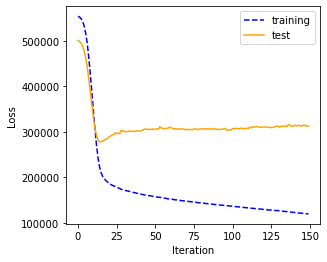

(train rmse, test rmse)=(343.92,559.63)


In [9]:
''' Plot loss-iteration for (30, 20) '''
PCA_full_NN_model = build_full_NN(64, 30, 20)
PCA_full_history = PCA_full_NN_model.fit(PCA_full_X_train, y_train, validation_data=(PCA_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_NN_model.predict(PCA_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_NN_model.predict(PCA_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

In [10]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_NN_model = build_full_NN(64, a, b)
    PCA_full_history = PCA_full_NN_model.fit(PCA_full_X_train, y_train, validation_data=(PCA_full_X_test, y_test), batch_size = 10, epochs = 50, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_NN_model.predict(PCA_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_NN_model.predict(PCA_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,430.32,535.37)
(first_layer, second_layer, train rmse, test rmse)=(8,6,419.75,535.15)
(first_layer, second_layer, train rmse, test rmse)=(8,8,444.24,540.71)
(first_layer, second_layer, train rmse, test rmse)=(8,10,424.77,550.71)
(first_layer, second_layer, train rmse, test rmse)=(8,12,418.28,543.21)
(first_layer, second_layer, train rmse, test rmse)=(8,14,422.63,552.71)
(first_layer, second_layer, train rmse, test rmse)=(8,16,417.97,542.77)
(first_layer, second_layer, train rmse, test rmse)=(8,18,417.96,541.67)
(first_layer, second_layer, train rmse, test rmse)=(8,20,412.66,554.6)
(first_layer, second_layer, train rmse, test rmse)=(8,22,414.31,555.2)
(first_layer, second_layer, train rmse, test rmse)=(8,24,413.26,558.47)
(first_layer, second_layer, train rmse, test rmse)=(10,4,437.74,541.48)
(first_layer, second_layer, train rmse, test rmse)=(10,6,426.02,544.43)
(first_layer, second_layer, train rmse, test rmse)=(10,8,422.56,536.6

In [11]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(12, 4, 433.3528365745512, 525.8831064083184)

much worse(+80) than lasso-selected NN

now try again but only use lasso selected

In [38]:
lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]
y = processed_CLIs_df[['Overall_Survival']]

#PCA
# apply PCA to reduce the dimensionality of the data(5->3)
scalar = StandardScaler()
lasso_genomic_df_0_sc = pd.DataFrame(scalar.fit_transform(lasso_genomic_df_0)) #scaling the data
pca = PCA(n_components = 3)
pca.fit(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pca.transform(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pd.DataFrame(PCA_genomic_df_0,columns=["PC"+str(i) for i in range (1, 4)])

PCA_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, PCA_genomic_df_0)))
PCA_lasso_genomic_X = PCA_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
PCA_lasso_full_X = pd.merge(processed_CLIs_df, PCA_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
PCA_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)
PCA_lasso_full_X



,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,CLI_race_black or african american,CLI_race_white,CLI_ethnicity_hispanic or latino,CLI_ethnicity_not hispanic or latino,1,2,3
0,44.0,2002.0,80.0,0,0,1,0,0,1,0,0,1,0,1,1.161581,0.22435,1.020302
1,50.0,2003.0,100.0,1,0,1,0,0,1,0,0,1,0,1,-0.100296,-0.705846,0.158487
2,59.0,2002.0,80.0,1,0,1,0,0,1,0,0,1,0,1,-0.032237,0.941261,0.009237
3,56.0,2002.0,80.0,0,0,1,0,0,1,0,0,1,0,1,-0.112174,-0.229326,0.242185
4,40.0,2002.0,80.0,0,0,1,0,1,0,0,0,1,0,1,-0.194501,0.902665,-0.032838
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,44.0,2011.0,80.0,0,0,1,0,0,1,0,0,1,0,0,-0.089804,-0.070786,0.08865
486,64.0,2009.0,40.0,1,1,0,0,0,1,0,0,1,0,0,-0.005445,-0.771628,0.196231
487,68.0,2012.0,80.0,1,0,0,1,0,0,0,1,0,0,1,-1.952646,-0.613942,-0.274286
488,72.0,2012.0,80.0,0,1,0,1,0,0,0,1,0,0,1,-0.193396,-0.195537,0.067937


In [39]:
#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_lasso_full_X)
PCA_lasso_full_X = pd.DataFrame(zscore_scaler.transform(PCA_lasso_full_X), columns = PCA_lasso_full_X.columns)
PCA_lasso_full_X




c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


,CLI_years_to_birth,CLI_date_of_initial_pathologic_diagnosis,CLI_karnofsky_performance_score,CLI_gender_male,CLI_radiation_therapy_no,CLI_radiation_therapy_yes,CLI_histological_type_glioblastoma multiforme (gbm),CLI_histological_type_treated primary gbm,CLI_histological_type_untreated primary (de novo) gbm,CLI_race_asian,CLI_race_black or african american,CLI_race_white,CLI_ethnicity_hispanic or latino,CLI_ethnicity_not hispanic or latino,1,2,3
0,-1.024953,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,0.955013,0.270129,0.972834
1,-0.597283,-0.182247,1.670024,0.77544,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-0.072003,-0.640762,0.125715
2,0.044222,-0.380253,0.165774,0.77544,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-0.016611,0.972162,-0.020989
3,-0.169613,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-0.081670,-0.174131,0.207986
4,-1.310066,-0.380253,0.165774,-1.28959,-0.418402,0.493614,-0.216815,4.978903,-3.309263,-0.120386,-0.268719,0.373544,-0.144338,0.448308,-0.148674,0.934367,-0.062347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
485,-1.024953,1.401806,0.165774,-1.28959,-0.418402,0.493614,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,-2.230607,-0.063463,-0.018882,0.057070
486,0.400613,1.005793,-2.842725,0.77544,2.390048,-2.025874,-0.216815,-0.200847,0.302182,-0.120386,-0.268719,0.373544,-0.144338,-2.230607,0.005194,-0.705180,0.162816
487,0.685726,1.599812,0.165774,0.77544,-0.418402,-2.025874,4.612237,-0.200847,-3.309263,-0.120386,3.721355,-2.677063,-0.144338,0.448308,-1.579592,-0.550765,-0.299677
488,0.970839,1.599812,0.165774,-1.28959,2.390048,-2.025874,4.612237,-0.200847,-3.309263,-0.120386,3.721355,-2.677063,-0.144338,0.448308,-0.147775,-0.141044,0.036710


In [40]:
y = processed_CLIs_df[['Overall_Survival']]
PCA_lasso_full_X_train, PCA_lasso_full_X_test, y_train, y_test = train_test_split(PCA_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
PCA_lasso_full_X_train = sc.fit_transform(PCA_lasso_full_X_train)
PCA_lasso_full_X_test = sc.transform(PCA_lasso_full_X_test)
PCA_lasso_full_X_train



c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[ 0.47175025, -0.17383308, -2.73306647, ..., -0.0967826 ,
        -0.26157372, -0.01233643],
       [-0.01563028,  0.63258784,  0.91847428, ...,  0.55497422,
         0.07899042, -0.10598033],
       [ 0.47175025,  0.83419307, -1.27245017, ...,  0.13245916,
        -0.02501456, -0.82369697],
       ...,
       [ 0.54137604,  0.43098261, -1.27245017, ..., -0.008873  ,
        -0.35384895,  0.09379825],
       [ 0.75025341,  0.83419307,  0.18816613, ..., -0.09862201,
        -0.20228038,  0.05317388],
       [ 0.26287288, -0.77864877,  0.18816613, ..., -0.00680109,
         0.65647143, -0.04785447]])

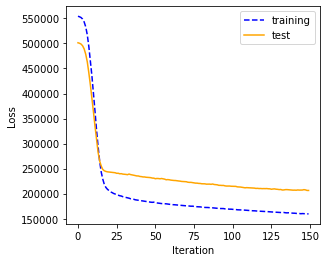

(train rmse, test rmse)=(398.53,454.28)


In [41]:
''' Plot loss-iteration for (30, 20) '''
PCA_full_lasso_NN_model = build_full_NN(17,30, 20)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

In [30]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_lasso_NN_model = build_full_NN(17, a, b)
    PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,430.93,476.99)
(first_layer, second_layer, train rmse, test rmse)=(8,6,430.7,481.8)
(first_layer, second_layer, train rmse, test rmse)=(8,8,430.62,492.5)
(first_layer, second_layer, train rmse, test rmse)=(8,10,418.98,480.2)
(first_layer, second_layer, train rmse, test rmse)=(8,12,429.04,499.32)
(first_layer, second_layer, train rmse, test rmse)=(8,14,421.4,470.68)
(first_layer, second_layer, train rmse, test rmse)=(8,16,420.88,467.73)
(first_layer, second_layer, train rmse, test rmse)=(8,18,416.83,472.13)
(first_layer, second_layer, train rmse, test rmse)=(8,20,421.61,471.89)
(first_layer, second_layer, train rmse, test rmse)=(8,22,421.99,466.89)
(first_layer, second_layer, train rmse, test rmse)=(8,24,417.75,465.65)
(first_layer, second_layer, train rmse, test rmse)=(10,4,435.97,497.93)
(first_layer, second_layer, train rmse, test rmse)=(10,6,430.19,467.12)
(first_layer, second_layer, train rmse, test rmse)=(10,8,429.67,477.88)


In [31]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(22, 24, 397.35651774723965, 441.2149610239887)

Text(0, 0.5, 'second_layer_nodes')

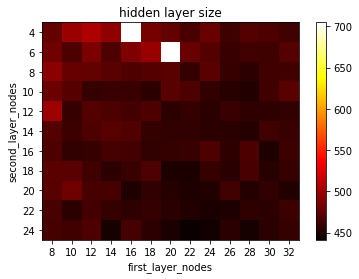

In [32]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")


This already beats the plain lasso selected record. Since 2nd layer is boundary case in (22,24), lets further explore neighbouring combinations 

In [42]:
PCA_lasso_full_X_train.shape

(392, 17)

In [43]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(14, 34,2):
    for y in range(20, 34,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_lasso_NN_model = build_full_NN(17, a, b)
    PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(14,20,404.99,454.26)
(first_layer, second_layer, train rmse, test rmse)=(14,22,408.98,464.33)
(first_layer, second_layer, train rmse, test rmse)=(14,24,409.43,457.75)
(first_layer, second_layer, train rmse, test rmse)=(14,26,423.34,468.16)
(first_layer, second_layer, train rmse, test rmse)=(14,28,398.23,454.21)
(first_layer, second_layer, train rmse, test rmse)=(14,30,402.92,458.77)
(first_layer, second_layer, train rmse, test rmse)=(14,32,400.39,452.72)
(first_layer, second_layer, train rmse, test rmse)=(16,20,417.72,464.28)
(first_layer, second_layer, train rmse, test rmse)=(16,22,410.74,461.4)
(first_layer, second_layer, train rmse, test rmse)=(16,24,401.56,456.26)
(first_layer, second_layer, train rmse, test rmse)=(16,26,400.38,446.22)
(first_layer, second_layer, train rmse, test rmse)=(16,28,410.39,468.51)
(first_layer, second_layer, train rmse, test rmse)=(16,30,399.29,442.17)
(first_layer, second_layer, train rmse, test rmse)=(

In [44]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(32, 24, 390.19466562623063, 440.9650426135043)

Text(0, 0.5, 'second_layer_nodes')

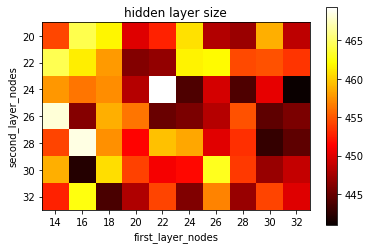

In [46]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(14, 34,2)] for second_layer in range(20, 34,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 10), labels=range(14, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 7), labels=range(20, 34,2))
plt.ylabel("second_layer_nodes")


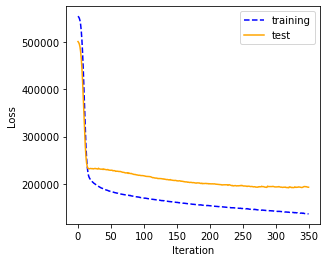

(train rmse, test rmse)=(368.9,439.47)


In [49]:
#try add epochs as the curve still underfits at 150
''' Plot loss-iteration for (32, 24) '''
PCA_full_lasso_NN_model = build_full_NN(17,32, 24)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 350, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")

repeat on using top 4/2 columns(tested 3)

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

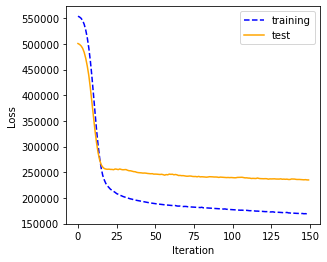

(train rmse, test rmse)=(410.3,484.79)


In [51]:
#2 cols

lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]

#PCA
# Perform PCA matrix factorization to extract features
scalar = StandardScaler()
lasso_genomic_df_0_sc = pd.DataFrame(scalar.fit_transform(lasso_genomic_df_0)) #scaling the data
pca = PCA(n_components = 2)
pca.fit(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pca.transform(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pd.DataFrame(PCA_genomic_df_0,columns=["PC"+str(i) for i in range (1, 3)])


PCA_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, PCA_genomic_df_0)))
PCA_lasso_genomic_X = PCA_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
PCA_lasso_full_X = pd.merge(processed_CLIs_df, PCA_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
PCA_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_lasso_full_X)
PCA_lasso_full_X = pd.DataFrame(zscore_scaler.transform(PCA_lasso_full_X), columns = PCA_lasso_full_X.columns)

y = processed_CLIs_df[['Overall_Survival']]
PCA_lasso_full_X_train, PCA_lasso_full_X_test, y_train, y_test = train_test_split(PCA_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
PCA_lasso_full_X_train = sc.fit_transform(PCA_lasso_full_X_train)
PCA_lasso_full_X_test = sc.transform(PCA_lasso_full_X_test)

''' Plot loss-iteration for (14, 24) '''
PCA_full_lasso_NN_model = build_full_NN(16,14, 24)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


In [53]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_lasso_NN_model = build_full_NN(16, a, b)
    PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,442.06,521.9)
(first_layer, second_layer, train rmse, test rmse)=(8,6,431.78,506.36)
(first_layer, second_layer, train rmse, test rmse)=(8,8,431.15,508.49)
(first_layer, second_layer, train rmse, test rmse)=(8,10,429.65,509.23)
(first_layer, second_layer, train rmse, test rmse)=(8,12,425.11,489.97)
(first_layer, second_layer, train rmse, test rmse)=(8,14,420.19,487.11)
(first_layer, second_layer, train rmse, test rmse)=(8,16,421.67,499.71)
(first_layer, second_layer, train rmse, test rmse)=(8,18,424.35,496.86)
(first_layer, second_layer, train rmse, test rmse)=(8,20,427.55,511.08)
(first_layer, second_layer, train rmse, test rmse)=(8,22,428.62,506.33)
(first_layer, second_layer, train rmse, test rmse)=(8,24,411.39,486.97)
(first_layer, second_layer, train rmse, test rmse)=(10,4,441.21,535.32)
(first_layer, second_layer, train rmse, test rmse)=(10,6,427.52,504.74)
(first_layer, second_layer, train rmse, test rmse)=(10,8,431.22,499.

In [54]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(28, 20, 399.9813882148073, 475.5985055546256)

Text(0, 0.5, 'second_layer_nodes')

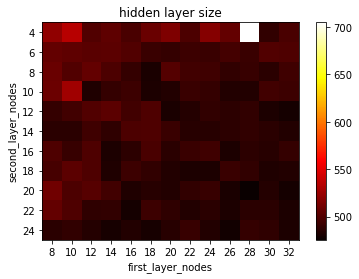

In [55]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")


much worse than col=3

c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\Public\Anaconda\lib

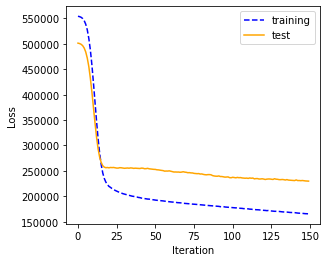

(train rmse, test rmse)=(405.87,479.38)


In [58]:
#4 cols

lasso_genomic_df_0 = genomic_df_0[["SMG_mutsig2.0_SFT2D1_cosmic","Amp_8q24.21 ","Del_1p36.32 ","Del_10p11.23","CN_1p_Amp"]]

#PCA
# Perform PCA matrix factorization to extract features
scalar = StandardScaler()
lasso_genomic_df_0_sc = pd.DataFrame(scalar.fit_transform(lasso_genomic_df_0)) #scaling the data
pca = PCA(n_components = 4)
pca.fit(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pca.transform(lasso_genomic_df_0_sc)
PCA_genomic_df_0 = pd.DataFrame(PCA_genomic_df_0,columns=["PC"+str(i) for i in range (1, 5)])


PCA_lasso_genomic_X = pd.DataFrame(np.column_stack((genomic_df['tcga_participant_barcode'].values, PCA_genomic_df_0)))
PCA_lasso_genomic_X = PCA_lasso_genomic_X.rename(columns={0: 'tcga_participant_barcode'})


#merge CLI and Genomic
PCA_lasso_full_X = pd.merge(processed_CLIs_df, PCA_lasso_genomic_X, on='tcga_participant_barcode', how='inner')
PCA_lasso_full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_lasso_full_X)
PCA_lasso_full_X = pd.DataFrame(zscore_scaler.transform(PCA_lasso_full_X), columns = PCA_lasso_full_X.columns)

y = processed_CLIs_df[['Overall_Survival']]
PCA_lasso_full_X_train, PCA_lasso_full_X_test, y_train, y_test = train_test_split(PCA_lasso_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
PCA_lasso_full_X_train = sc.fit_transform(PCA_lasso_full_X_train)
PCA_lasso_full_X_test = sc.transform(PCA_lasso_full_X_test)

''' Plot loss-iteration for (14, 24) '''
PCA_full_lasso_NN_model = build_full_NN(18,14, 24)
PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_lasso_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_lasso_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


In [59]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_lasso_NN_model = build_full_NN(18, a, b)
    PCA_full_lasso_history = PCA_full_lasso_NN_model.fit(PCA_lasso_full_X_train, y_train, validation_data=(PCA_lasso_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_lasso_NN_model.predict(PCA_lasso_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))



(first_layer, second_layer, train rmse, test rmse)=(8,4,421.72,473.93)
(first_layer, second_layer, train rmse, test rmse)=(8,6,431.99,512.98)
(first_layer, second_layer, train rmse, test rmse)=(8,8,429.2,500.43)
(first_layer, second_layer, train rmse, test rmse)=(8,10,420.65,500.43)
(first_layer, second_layer, train rmse, test rmse)=(8,12,425.11,491.81)
(first_layer, second_layer, train rmse, test rmse)=(8,14,418.21,471.06)
(first_layer, second_layer, train rmse, test rmse)=(8,16,421.12,466.48)
(first_layer, second_layer, train rmse, test rmse)=(8,18,425.39,490.78)
(first_layer, second_layer, train rmse, test rmse)=(8,20,417.5,480.14)
(first_layer, second_layer, train rmse, test rmse)=(8,22,406.63,474.25)
(first_layer, second_layer, train rmse, test rmse)=(8,24,418.16,472.86)
(first_layer, second_layer, train rmse, test rmse)=(10,4,426.85,498.78)
(first_layer, second_layer, train rmse, test rmse)=(10,6,413.23,500.32)
(first_layer, second_layer, train rmse, test rmse)=(10,8,422.35,479.9

In [60]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(12, 24, 408.3623406059652, 458.99708706628167)

Text(0, 0.5, 'second_layer_nodes')

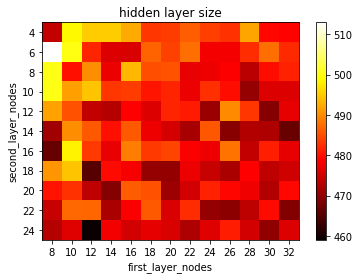

In [61]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")


still not as good as col=3. thus col=3 is optimal

Lastly, try PCA on both CLIs and genomic, instead on transforming genomic only

In [ ]:
#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
genomic_df_0

,tcga_participant_barcode,CLUS_mRNA_cNMF,CLUS_mRNA_cHierarchical,CLUS_miR_cNMF,CLUS_miR_cHierarchical,CLUS_CN_cNMF,CLUS_Methlyation_cNMF,CLUS_RPPA_cNMF,CLUS_RPPA_cHierarchical,CLUS_mRNAseq_cNMF,...,Del_SMYD3_1q44_mRNA,Del_TCL1A_14q24.2_mRNA,Del_TCL6_14q24.2_mRNA,Del_TFRC_3q29_mRNA,Del_TNFAIP3_6q22.1_mRNA,Del_TP53_17p13.1_mRNA,Del_TRIP11_14q24.2_mRNA,Del_TSHR_14q24.2_mRNA,Del_WIF1_12q15_mRNA,Del_WWOX_16q23.1_mRNA
0,TCGA-02-0001,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TCGA-02-0003,1.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,TCGA-02-0004,1.0,1.0,1.0,2.0,0.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TCGA-02-0006,0.0,0.0,1.0,2.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TCGA-02-0007,2.0,1.0,2.0,1.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590,TCGA-87-5896,3.0,3.0,2.0,3.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
591,TCGA-OX-A56R,0.0,0.0,0.0,0.0,2.0,0.0,4.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
592,TCGA-RR-A6KA,0.0,0.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
593,TCGA-RR-A6KB,0.0,0.0,0.0,0.0,1.0,0.0,3.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# on full_X
#3 cols

#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)



Missing values:
tcga_participant_barcode                                 0
CLI_years_to_birth                                       0
Overall_Survival                                         0
CLI_date_of_initial_pathologic_diagnosis                 0
CLI_karnofsky_performance_score                          0
CLI_gender_male                                          0
CLI_radiation_therapy_no                                 0
CLI_radiation_therapy_yes                                0
CLI_histological_type_glioblastoma multiforme (gbm)      0
CLI_histological_type_treated primary gbm                0
CLI_histological_type_untreated primary (de novo) gbm    0
CLI_race_asian                                           0
CLI_race_black or african american                       0
CLI_race_white                                           0
CLI_ethnicity_hispanic or latino                         0
CLI_ethnicity_not hispanic or latino                     0
dtype: int64


In [62]:
# on full_X
#5 cols
#getting genomic features
genomic_df = df.drop(df.columns[range(1, 13)],axis=1,inplace=False)
#fill null by 0
genomic_df_0 = genomic_df.fillna(value=0, inplace = False)
full_X = pd.merge(processed_CLIs_df, genomic_df_0, on='tcga_participant_barcode', how='inner')
full_X.drop(['tcga_participant_barcode', 'Overall_Survival'], axis=1, inplace = True)

#PCA
# Perform PCA matrix factorization to extract features
scalar = StandardScaler()
full_X_sc = pd.DataFrame(scalar.fit_transform(full_X)) #scaling the data
pca = PCA(n_components = 5)
pca.fit(full_X_sc)
PCA_full_X = pca.transform(full_X_sc)
PCA_full_X = pd.DataFrame(PCA_full_X,columns=["PC"+str(i) for i in range (1, 6)])

#normalization
zscore_scaler = preprocessing.StandardScaler().fit(PCA_full_X)
PCA_full_X = pd.DataFrame(zscore_scaler.transform(PCA_full_X), columns = PCA_full_X.columns)
PCA_full_X

,PC1,PC2,PC3,PC4,PC5
0,-0.593351,-0.925817,-0.855341,0.869160,-0.120640
1,-0.491190,0.538364,0.822617,-0.335258,1.670647
2,-0.601980,-1.323983,-0.537365,0.903247,-0.202325
3,-0.591162,-0.193168,-0.158892,-0.097147,-0.264393
4,-0.578549,-0.343912,0.494496,-1.148041,-1.112466
...,...,...,...,...,...
485,-0.522472,0.172244,0.503917,0.616253,1.387630
486,-0.480606,1.383060,0.815624,-0.402999,1.185881
487,-0.561104,0.043095,0.763766,-1.576325,-1.195522
488,-0.595180,0.045307,-0.659790,0.588839,0.040687


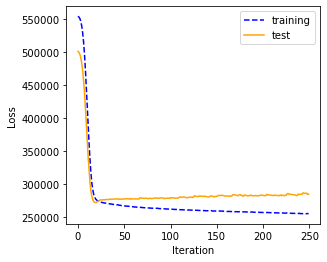

(train rmse, test rmse)=(504.34,533.47)


In [63]:
y = processed_CLIs_df[['Overall_Survival']]
PCA_full_X_train, PCA_full_X_test, y_train, y_test = train_test_split(PCA_full_X, y, test_size=0.2,random_state =42)
#NN
sc = StandardScaler()
PCA_full_X_train = sc.fit_transform(PCA_full_X_train)
PCA_full_X_test = sc.transform(PCA_full_X_test)

''' Plot loss-iteration for (32, 24) '''
PCA_full_NN_model = build_full_NN(5, 32, 24)
PCA_full_history = PCA_full_NN_model.fit(PCA_full_X_train, y_train, validation_data=(PCA_full_X_test, y_test), batch_size = 10, epochs = 250, verbose = 0)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(PCA_full_history.history["loss"], label="training", color="blue", linestyle="dashed")
plt.plot(PCA_full_history.history["val_loss"], label="test", color="orange")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

plt.show()
train_rms = mean_squared_error(y_train, PCA_full_NN_model.predict(PCA_full_X_train, verbose=0), squared=False)
test_rms = mean_squared_error(y_test, PCA_full_NN_model.predict(PCA_full_X_test, verbose=0), squared=False)
print(f"(train rmse, test rmse)=({round(train_rms, 2)},{round(test_rms, 2)})")


In [64]:
#try different number of units in each hidden layer
num_hidden_unit= list()
for  x in range(8, 34,2):
    for y in range(4, 26,2):
        num_hidden_unit.append((x,y))

rmse_for_each_num_hidden = list()
for a, b in num_hidden_unit:
    PCA_full_NN_model = build_full_NN(5,a, b)
    PCA_full_history = PCA_full_NN_model.fit(PCA_full_X_train, y_train, validation_data=(PCA_full_X_test, y_test), batch_size = 10, epochs = 150, verbose = 0)
    train_rms = mean_squared_error(y_train, PCA_full_NN_model.predict(PCA_full_X_train, verbose=0), squared=False)
    test_rms = mean_squared_error(y_test, PCA_full_NN_model.predict(PCA_full_X_test, verbose=0), squared=False)

    print(f"(first_layer, second_layer, train rmse, test rmse)=({a},{b},{round(train_rms, 2)},{round(test_rms, 2)})")
    rmse_for_each_num_hidden.append((a,b,train_rms,test_rms))

(first_layer, second_layer, train rmse, test rmse)=(8,4,740.94,704.58)
(first_layer, second_layer, train rmse, test rmse)=(8,6,524.61,536.55)
(first_layer, second_layer, train rmse, test rmse)=(8,8,512.96,524.48)
(first_layer, second_layer, train rmse, test rmse)=(8,10,517.29,523.51)
(first_layer, second_layer, train rmse, test rmse)=(8,12,514.72,529.42)
(first_layer, second_layer, train rmse, test rmse)=(8,14,521.47,532.01)
(first_layer, second_layer, train rmse, test rmse)=(8,16,511.33,526.96)
(first_layer, second_layer, train rmse, test rmse)=(8,18,510.41,530.12)
(first_layer, second_layer, train rmse, test rmse)=(8,20,512.15,527.97)
(first_layer, second_layer, train rmse, test rmse)=(8,22,510.0,528.9)
(first_layer, second_layer, train rmse, test rmse)=(8,24,509.74,532.1)
(first_layer, second_layer, train rmse, test rmse)=(10,4,515.82,526.22)
(first_layer, second_layer, train rmse, test rmse)=(10,6,517.2,528.56)
(first_layer, second_layer, train rmse, test rmse)=(10,8,517.11,526.16)

In [65]:
min(rmse_for_each_num_hidden, key = lambda t: t[3])

(8, 10, 517.291049086537, 523.51127849803)

Text(0, 0.5, 'second_layer_nodes')

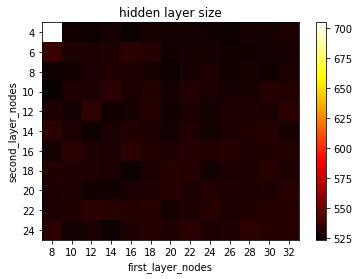

In [66]:
#convert list to dict
rmse_dict = dict()
for first_layer, second_layer, train_rmse, test_rmse in rmse_for_each_num_hidden:
    rmse_dict[(first_layer, second_layer)] = test_rmse
    
plt.figure(figsize=(6, 4))
# you should have a dictionary here.
a3 = np.array([[rmse_dict[(first_layer, second_layer)] for first_layer in range(8, 34,2)] for second_layer in range(4, 26,2)])
plt.title('hidden layer size')
plt.imshow(a3, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.xticks(ticks=range(0, 13), labels=range(8, 34,2))
plt.xlabel("first_layer_nodes")
plt.yticks(ticks=range(0, 11), labels=range(4, 26,2))
plt.ylabel("second_layer_nodes")

not as good as PCA on only genomic features
